In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
from pynufft import NUFFT
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

mm = 1E-3
C = scipy.constants.c

def set_font(fontsize=18, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font(fontsize=15)

def fft_resample(img, Nx, Ny, Nz):
    '''
    Resamples image img by padding or truncating in the Fourier domain.

    '''
    img = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(img)))
    scal = img.size
    img = padortruncate(img, Nx, Ny, Nz)
    scal = img.size / scal
    img = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(img)))*scal

    return img

def padortruncate(array, dx, dy, dz, val_bg=0):
    '''
    Pads (with value val_bg) or truncates array depending on whether array dimensions are great than or less than (dx, dy)

    '''
    dx = int(dx)
    dy = int(dy)
    dz = int(dz)
    nx = max((dx-array.shape[0])//2, 0)
    ny = max((dy-array.shape[1])//2, 0)
    nz = max((dz-array.shape[2])//2, 0)
    px = max((array.shape[0]-dx)//2, 0)
    py = max((array.shape[1]-dy)//2, 0)
    pz = max((array.shape[2]-dz)//2, 0)
    newarray = val_bg * np.ones((dx, dy, dz), dtype=array.dtype)
    cx = min(array.shape[0], dx)
    cy = min(array.shape[1], dy)
    cz = min(array.shape[2], dz)
    newarray[nx:nx+cx, ny:ny+cy, nz:nz+cz] = array[px:px+cx, py:py+cy, pz:pz+cz]

    return newarray

def G(k, R):
    return np.exp(-1j*k*R)/R

### Load data & antenna coordinates

NOTES:
second scan of wall1 with drywall.


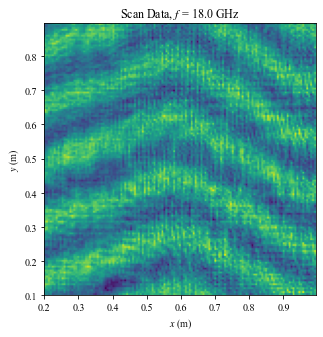

In [2]:
d_antennas = .035        # distance between tx/rx antennas
fc = 22E9
bw = 8E9

mat = scipy.io.loadmat(r'..\..\..\Data\wall1_with_drywall_2022-11-13.mat')
notes = list(mat['notes'])
print('NOTES:')
for i in range(len(notes)):
        print(notes[i])
f = mat['f'][0,:]
f_indx = np.argwhere(np.abs(f-fc)<=bw/2)[:,0]
f = f[f_indx]
lam = C/f
k = 2*np.pi/lam
Xa = np.flip(mat['X']*mm, axis=(0,1))   # flipping to recover right-handed coordinate systems
Ya = np.flip(mat['Y']*mm, axis=(0,1))       # flipping because origin of scan stage was at top left
Za = np.zeros_like(Xa)
xa = np.unique(Xa)
ya = np.unique(Ya)
delta_xa = xa[1] - xa[0]
delta_ya = ya[1] - ya[0]
measurements = np.flip(mat['measurements'], axis=(0,1))
measurements = measurements[:,:,f_indx]
z_offset = mat['z_offset'][0,0]*mm

### load background
mat = scipy.io.loadmat(r'..\..\..\Data\background_2022-10-29.mat')
bg = np.flip(mat['measurements'], axis=(0,1))
bg = bg[:,:,f_indx]

### subtract background from measurements
measurements = measurements - bg

set_font(fontsize=15)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.real(measurements[:,:,0]),
           extent=(np.amin(xa), np.amax(xa), np.amin(ya), np.amax(ya)),
           origin='lower')
plt.title('Scan Data, $f$ = {} GHz'.format(f[0]*1E-9))
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.show()

### truncate scan
Lxa_new = 0.8
Lya_new = 0.8

indx_center_x = xa.size//2
indx_center_y = ya.size//2

Xa = Xa[int(indx_center_y-Lya_new//(2*delta_ya)):int((indx_center_y+Lya_new//(2*delta_ya))),
        int(indx_center_x-Lxa_new//(2*delta_xa)):int((indx_center_x+Lxa_new//(2*delta_xa)))]
Ya = Ya[int(indx_center_y-Lya_new//(2*delta_ya)):int((indx_center_y+Lya_new//(2*delta_ya))),
        int(indx_center_x-Lxa_new//(2*delta_xa)):int((indx_center_x+Lxa_new//(2*delta_xa)))]
Za = np.zeros_like(Xa)
measurements = measurements[int(indx_center_y-Lya_new//(2*delta_ya)):int((indx_center_y+Lya_new//(2*delta_ya))),
                            int(indx_center_x-Lxa_new//(2*delta_xa)):int((indx_center_x+Lxa_new//(2*delta_xa))),
                            :]

xa_center = np.mean(Xa)
ya_center = np.mean(Ya)

Na = Xa.size
Nf = f.size
M = Na*Nf                           # total number of measurements
Lxa = np.amax(Xa) - np.amin(Xa)
Lya = np.amax(Ya) - np.amin(Ya)

g = np.reshape(measurements, (M, 1))

### Define reconstruction region

In [3]:
Lxs = 1
Lys = 1
Lzs = 1

cr_res_x = np.amin(lam)*z_offset/(2*Lxa)
cr_res_y = np.amin(lam)*z_offset/(2*Lya)
r_res_z = C/bw

delta_xs = cr_res_x/2
delta_ys = cr_res_y/2
delta_zs = r_res_z/2

xs_offset = 0.1
ys_offset = 0
zs_offset = z_offset

Nkx, Nky, Nkz = (int(4*np.amax(k) * Lxs / (2*np.pi)), 
                 int(4*np.amax(k) * Lys / (2*np.pi)), 
                 int(4*np.amax(k) * Lzs / (2*np.pi)))
Nx, Ny, Nz = (int(2*np.pi * Nkx / (4*np.amax(k) * delta_xs)), 
              int(2*np.pi * Nky / (4*np.amax(k) * delta_ys)), 
              int(2*np.pi * Nkz / (4*np.amax(k) * delta_zs)))

xs = np.arange(-np.floor(Nx/2), np.ceil(Nx/2)) * delta_xs + xs_offset
ys = np.arange(-np.floor(Ny/2), np.ceil(Ny/2)) * delta_ys + ys_offset
zs = np.arange(-np.floor(Nz/2), np.ceil(Nz/2)) * delta_zs + zs_offset
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')

### Reconstruct

In [4]:
pad_amt = 100
measurements_pad = np.pad(measurements, ((pad_amt, pad_amt), (pad_amt, pad_amt), (0, 0)), mode='constant')
Nx_pad = measurements_pad.shape[1]
Ny_pad = measurements_pad.shape[0]
measurements_ft = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(
                        measurements_pad,
                        axes=(0,1)), axes=(0,1)), axes=(0,1))
delta_kx = 2*np.pi/(delta_xa * Nx_pad)
delta_ky = 2*np.pi/(delta_ya * Ny_pad)
kx = np.arange(-np.floor(Nx_pad/2), np.ceil(Nx_pad/2)) * delta_kx
ky = np.arange(-np.floor(Ny_pad/2), np.ceil(Ny_pad/2)) * delta_ky
Kx, Ky, K = np.meshgrid(kx.astype(np.complex64), ky.astype(np.complex64), k.astype(np.complex64), indexing='xy')
Kz = np.sqrt(4*K**2 - Kx**2 - Ky**2)
Kz[np.imag(Kz)!=0] = 0
measurements_ft[np.imag(Kz)!=0] = 0

filt = np.nan_to_num(K / Kz**2)
measurements_ft = measurements_ft * np.exp(1j * Kx * xs_offset) * np.exp(1j * Ky * ys_offset) * np.exp(1j * Kz * zs_offset) / filt

C:\Users\User\AppData\Local\Temp\ipykernel_23492\737437263.py:17: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Temp\ipykernel_23492\737437263.py:17: RuntimeWarning:

invalid value encountered in true_divide



In [5]:
NufftObj = NUFFT()
Jd = (3, 3, 3)

K_array = np.stack((np.real(Kx).flatten(), np.real(Ky).flatten(), np.real(Kz).flatten()), axis=1) * np.pi/(2*np.amax(k))   # normalizing to pi
measurements_reshape = measurements_ft.flatten()

NufftObj.plan(K_array, (Nx, Ny, Nz), (Nkx, Nky, Nkz), Jd)

im = NufftObj.adjoint(measurements_reshape)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pynufft\nufft\__init__.py:88: SyntaxWarning:

"is" with a literal. Did you mean "=="?

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pynufft\nufft\__init__.py:88: SyntaxWarning:

"is" with a literal. Did you mean "=="?

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pynufft\nufft\__init__.py:88: SyntaxWarning:

"is" with a literal. Did you mean "=="?

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pynufft\src\_helper\helper.py:775: SyntaxWarning:

"is" with a literal. Did you mean "=="?

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pynufft\src\_helper\helper.py:783: SyntaxWarning:

"is" with a literal. Did you mean "=="?

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pynufft\src\_helper\helper.py:775: SyntaxWarning:

"is" with a literal. Did you mean "=="?

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pynufft\src\_helper\helper.py:783: SyntaxWa

KeyboardInterrupt: 

### Plot

In [ ]:
N_interp = 1

im_interpolate = np.abs(fft_resample(im, N_interp*im.shape[0], N_interp*im.shape[1], N_interp*im.shape[2]))

im_2d = np.transpose(np.abs(np.mean(im_interpolate, 2))**2, (1,0))

%matplotlib qt
set_font(fontsize=15)
plt.figure()
plt.imshow(im_2d,
           extent=(np.amin(xs), np.amax(xs), np.amin(ys), np.amax(ys)),
           origin='lower')
# plt.clim(-20, 0)
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Reconstruction')
plt.colorbar(label='dB')
plt.show()

##### 3D plot

In [7]:
x_interp = np.linspace(np.amin(xs), np.amax(xs), im.shape[0])
y_interp = np.linspace(np.amin(ys), np.amax(ys), im.shape[1])
z_interp = np.linspace(np.amin(zs), np.amax(zs), im.shape[2])
X_interp, Y_interp, Z_interp = np.meshgrid(x_interp, y_interp, z_interp, indexing='ij')

im_plot = np.abs(im_interpolate)**2
im_plot = 10*np.log10(im_plot/np.amax(im_plot))

surface_count = 20
opacity = .1
isomin = -10
isomax = 0

fig = go.Figure(data=go.Volume(
                    x=Z_interp.flatten(),
                    y=X_interp.flatten(),
                    z=Y_interp.flatten(),
                    value=im_plot.flatten(),
                    name='Reconstruction',
                    isomin=isomin,
                    isomax=isomax,
                    opacity=opacity, # needs to be small to see through all surfaces
                    surface_count=surface_count, # needs to be a large number for good volume rendering
                    colorscale='Turbo',
                    caps= dict(x_show=False, y_show=False, z_show=False),
                    opacityscale='uniform'
                ))
fig.show()